# Guide to Data
A notebook guide to working with PUNCH FITS files in Python

This Jupyter Notebook presents a comprehensive guide to the analysis and visualization of PUNCH FITS files using Python. The guide leverages a suite of Python libraries, including `matplotlib` for data visualization, numpy for numerical operations, `astropy` for FITS file handling and WCS manipulation, `sunpy` for solar data analysis, and `ndcube` for multi-dimensional data handling. The notebook serves as a robust resource for researchers and scientists, providing them with the tools and knowledge to effectively manipulate and interpret PUNCH FITS files. The guide's step-by-step approach, coupled with code snippets and detailed explanations, ensures a user-friendly experience, promoting the accessibility of PUNCH data for a wider scientific community.

To install these dependencies, use `pip install -r requirements.txt` in your terminal. 

In [1]:
# Load libraries

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import numpy as np

from copy import deepcopy

from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u

from sunpy.map import Map

from ndcube import NDCube

/Users/clowder/work/punch/punch-5-meeting/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data loading

We first specify the file we wish to load. For this notebook, let's use the included L3 PAM file. Then, we'll load it two different ways:

1. With `astropy.io`
2. With `SunPy Maps`

The data are RICE compressed, so we'll have to look in the *second* at index 1 (since we're zero-indexed) HDU for the main data frame. There is also an uncertainty layer in the last HDU that we'll explore later. 

In [2]:
filename = 'example_data/PUNCH_L3_PAM_20240620000000.fits'

with fits.open(filename) as hdul:
    data = hdul[1].data
    header = hdul[1].header
    uncertainty = hdul[2].data

First, let's look at the shape of the data. For this data product, total brightness and polarized brightness are stacked along the first dimension. The uncertainty array corresponds on a pixel-to-pixel basis with the data array. 

In [3]:
data.shape, uncertainty.shape

((2, 4096, 4096), (2, 4096, 4096))

We can look in the header for details about the data. A few things to note:

- The header is divided into helpful sections such as "temporal information" and "instrument and spacecraft state." This aids in navigating the information. These sections are consistent for other products (with the addition of more sections depending on the product). 
- There are two world coordinate systems (WCS), one for the helio system and one for a celestial right ascension and declination system. They match each other and can be used interchangeably depending on the type of analysis. 
- The first dimension iterates over total brightness and polarized brightness, in that order. This is indicated by the `OBSLAYR1` and `OBSLAYR2` keywords. 

In [4]:
header

SIMPLE  = 'T       '           / Conforms to FITS Standard                      
BITPIX  =                  -32 / Number of bits per pixel                       
NAXIS   =                    3 / Number of axes                                 
NAXIS1  =                 4096 / Length of the first axis                       
NAXIS2  =                 4096 / Length of the second axis                      
NAXIS3  =                    2 / Length of the third axis                       
COMMENT ----- FITS Required ----------------------------------------------------
EXTNAME = 'PRIMARY DATA ARRAY' / Name of this binary table extension            
LONGSTRN= 'OGIP 1.0'           / The OGIP long string convention may be used    
COMMENT ----- Documentation, Contact, and Collection Metadata ------------------
DOI     = 'https://doi.org/TBD' / Data reference DOI                            
PROJECT = 'PUNCH   '                                                            
TITLE   = 'PUNCH Level-3 Pol

We can create `Astropy WCS` objects from the header. Since the data are three dimensional, the WCS will be three dimensions. Luckily, we can slice WCSes. 

In [5]:
data_wcs = WCS(header)
data_wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-ARC' 'HPLT-ARC' 'STOKES' 
CRVAL : 0.0 0.0 0.0 
CRPIX : 2047.5 2047.5 0.0 
PC1_1 PC1_2 PC1_3  : 1.0 0.0 0.0 
PC2_1 PC2_2 PC2_3  : 0.0 1.0 0.0 
PC3_1 PC3_2 PC3_3  : 0.0 0.0 1.0 
CDELT : 0.0225 0.0225 1.0 
NAXIS : 4096  4096  2

We can also access the celestial WCS by setting `key='A'`. "

In [6]:
data_wcs_celestial = WCS(header, key='A')
data_wcs_celestial

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---ARC' 'DEC--ARC' 'STOKES' 
CRVAL : 88.72529939915754 23.43076999917664 0.0 
CRPIX : 2047.5 2047.5 0.0 
PC1_1 PC1_2 PC1_3  : 0.9912781666299199 0.13178617667579878 0.0 
PC2_1 PC2_2 PC2_3  : -0.13178617667579878 0.9912781666299199 0.0 
PC3_1 PC3_2 PC3_3  : 0.0 0.0 1.0 
CDELT : -0.0225 0.0225 1.0 
NAXIS : 4096  4096  2

We can also use SunPy Maps to load the data. However, since Maps only support 2D images, it will warn us that it's truncating a dimension of the data and only showing the total brightness. We get a list of Maps where the first entry is the data and the second is the uncertainty. 

See https://docs.sunpy.org/en/stable/how_to/fix_map_metadata.html for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards. [sunpy.map.mapbase]


Observatory,PUNCH
Instrument,WFI+NFI Mosaic
Detector,
Measurement,530.0 nm
Wavelength,530.0 nm
Observation Date,2024-06-20 00:00:00
Exposure Time,Unknown
Dimension,[4096. 4096.] pix
Coordinate System,helioprojective
Scale,[0.0225 0.0225] deg / pix
Reference Pixel,[2046.5 2046.5] pix

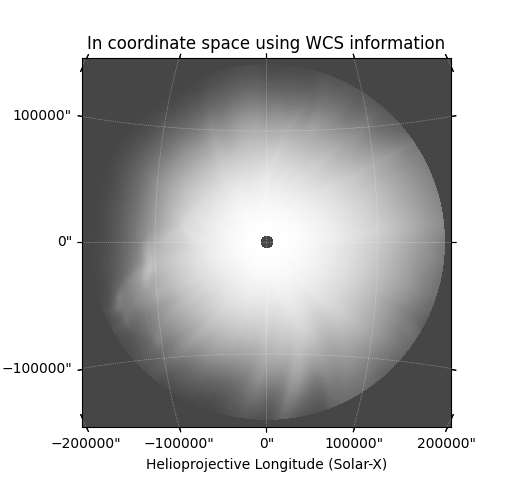
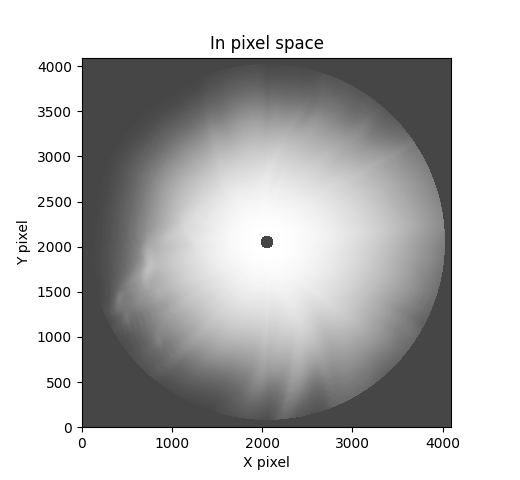
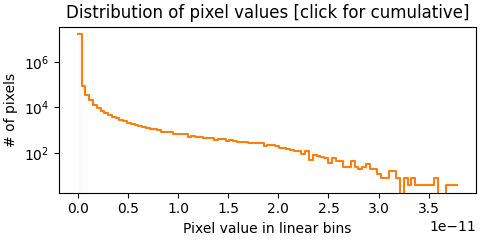
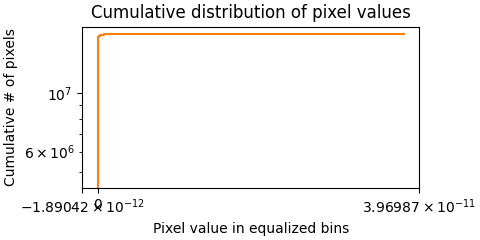

In [7]:
data_map = Map(filename)
data_map[0]

If you wish to make a map of the polarized brightness, we can also do that manually. 

See https://docs.sunpy.org/en/stable/how_to/fix_map_metadata.html for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards. [sunpy.map.mapbase]


Observatory,PUNCH
Instrument,WFI+NFI Mosaic
Detector,
Measurement,530.0 nm
Wavelength,530.0 nm
Observation Date,2024-06-20 00:00:00
Exposure Time,Unknown
Dimension,[4096. 4096.] pix
Coordinate System,helioprojective
Scale,[0.0225 0.0225] deg / pix
Reference Pixel,[2046.5 2046.5] pix

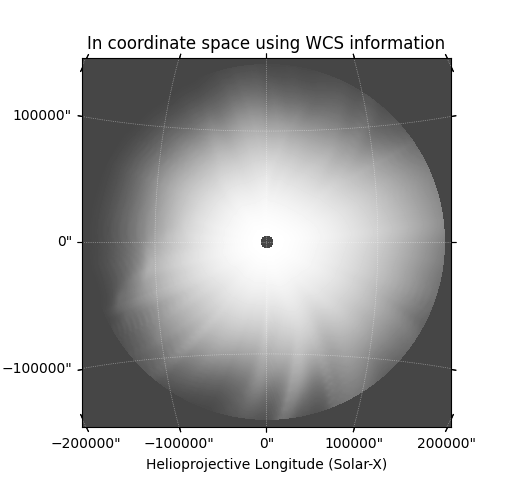
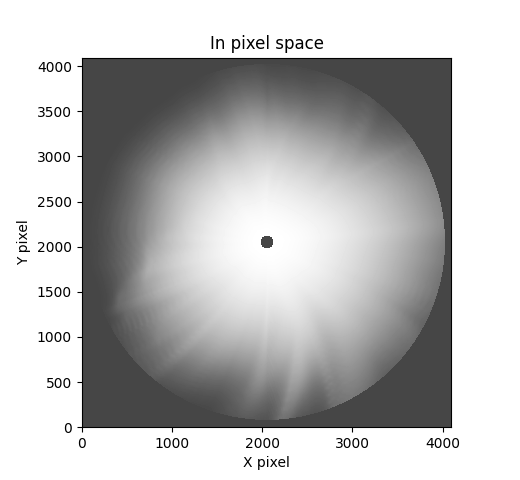
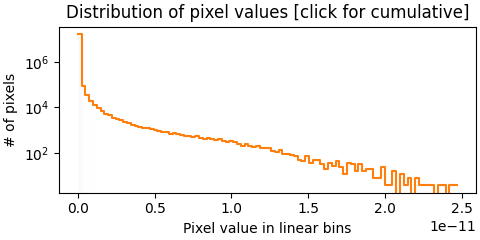
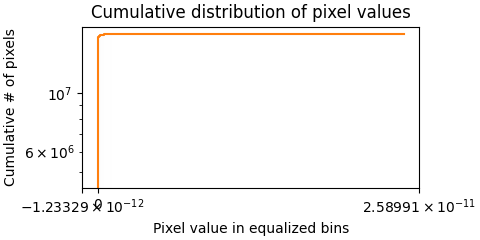

In [8]:
data_map = Map(data[1], header)
data_map

## Plotting data

There are many ways to plot the data. We are working on more visualization tools that will be available with the release of the `punchbowl` package. First, we can plot the SunPy map. 

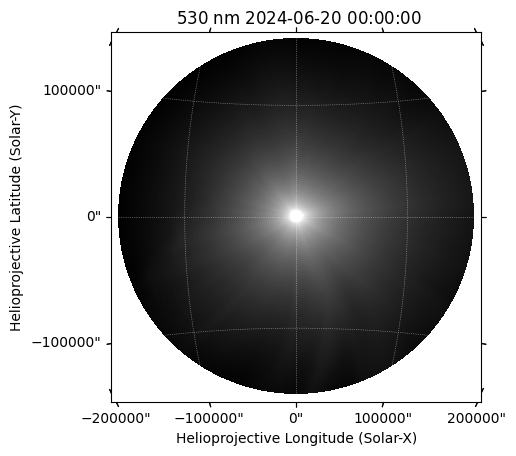

In [9]:
data_map.plot(norm='log')

We can also use Matplotlib directly to modify the plot however we want. Notice that we set the projection so it is coordinate aware. Remember we have to slice the WCS as `data_wcs[0]` instead of `data_wcs` because our data are 3D but we want to view only the spatial dimensions. 

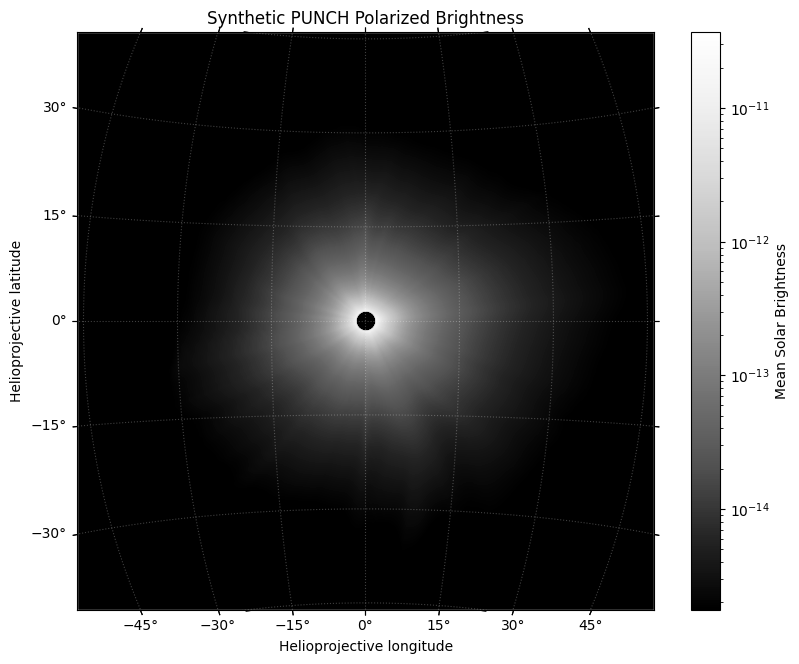

In [10]:
# Plot the data using matplotlib manually
fig, ax = plt.subplots(figsize=(9.5, 7.5), subplot_kw={'projection':data_wcs[0]})

im = ax.imshow(data[1], cmap='Greys_r', norm=LogNorm(vmin=1.77e-15, vmax=3.7e-11))

# set up the axis labels
lon, lat = ax.coords
lat.set_ticks(np.arange(-90, 90, 15) * u.degree)
lon.set_ticks(np.arange(-180, 180, 15) * u.degree)
lat.set_major_formatter('dd')
lon.set_major_formatter('dd')
ax.set_facecolor('black')
ax.coords.grid(color='white', alpha=.25, ls='dotted')
ax.set_xlabel("Helioprojective longitude")
ax.set_ylabel("Helioprojective latitude")
ax.set_title('Synthetic PUNCH Polarized Brightness')
fig.colorbar(im, ax=ax, label='Mean Solar Brightness')

Since we set the projection, we could also use the celestial WCS instead. 

/var/folders/8x/qm8fkjrx4hx850dzlrczjfw53pyj1t/T/ipykernel_26195/2803791681.py:19: UserWarning: Adding colorbar to a different Figure <Figure size 950x750 with 2 Axes> than <Figure size 950x750 with 2 Axes> which fig.colorbar is called on.
  fig.colorbar(im, ax=ax, label='Mean Solar Brightness')


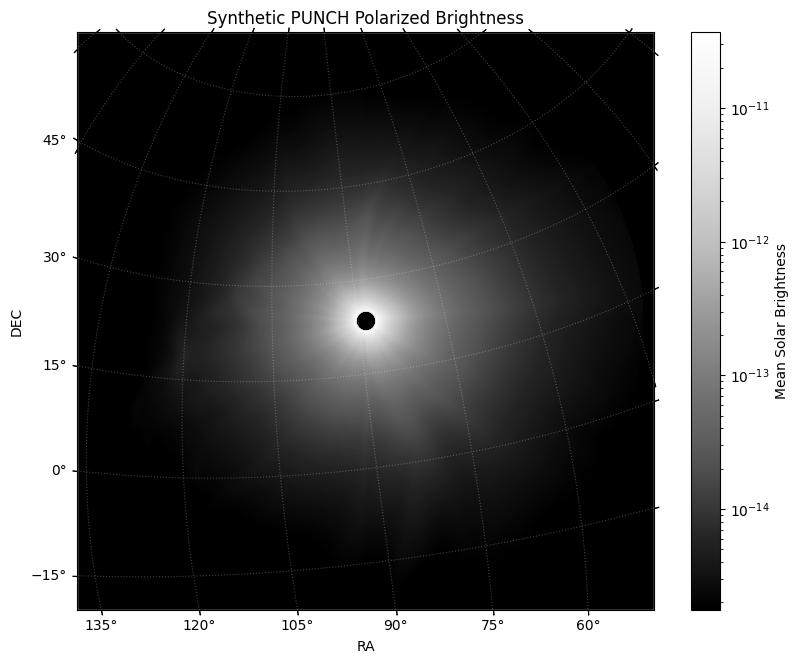

In [11]:
# Plot the data using matplotlib manually, using the celestial frame

fig, ax = plt.subplots(figsize=(9.5, 7.5), subplot_kw={'projection':data_wcs_celestial[0]})

ax.imshow(data[0], cmap='Greys_r', norm=LogNorm(vmin=1.77e-15, vmax=3.7e-11))


# set up the axis labels
lon, lat = ax.coords
lat.set_ticks(np.arange(-90, 90, 15) * u.degree)
lon.set_ticks(np.arange(-180, 180, 15) * u.degree)
lat.set_major_formatter('dd')
lon.set_major_formatter('dd')
ax.set_facecolor('black')
ax.coords.grid(color='white', alpha=.25, ls='dotted')
ax.set_xlabel("RA")
ax.set_ylabel("DEC")
ax.set_title('Synthetic PUNCH Polarized Brightness')
fig.colorbar(im, ax=ax, label='Mean Solar Brightness')

## Reprojecting the data

What if we want want to manipulate the images? We can use built-in tools of SunPy Maps. For example, we can reproject. 

Observatory,
Instrument,
Detector,
Measurement,Unknown
Wavelength,Unknown
Observation Date,2024-06-20 00:00:00
Exposure Time,Unknown
Dimension,[1024. 1024.] pix
Coordinate System,helioprojective
Scale,[0.0225 0.0225] deg / pix
Reference Pixel,[511. 511.] pix

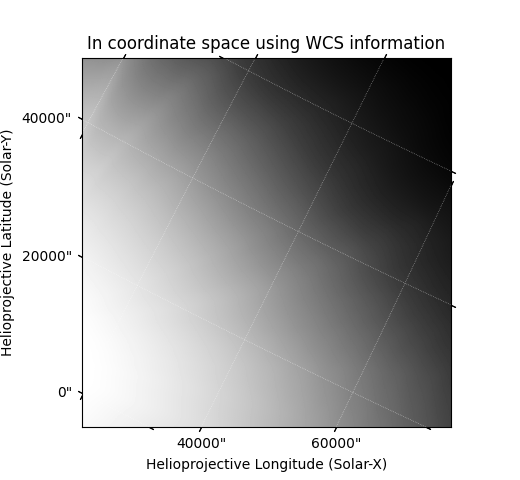
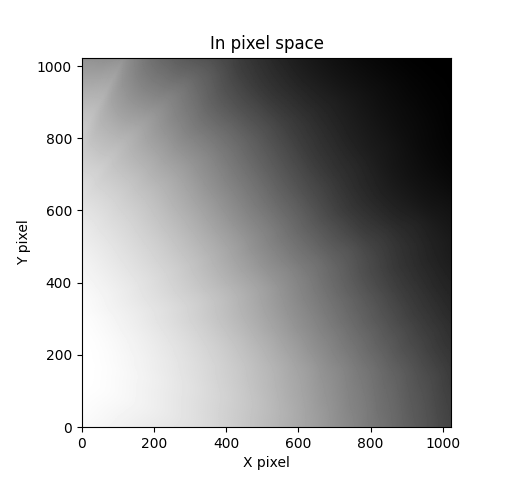
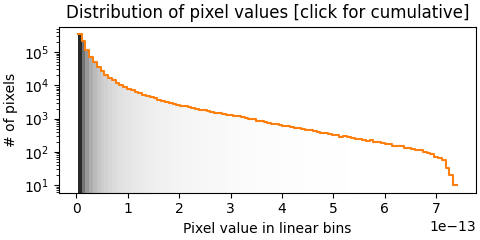
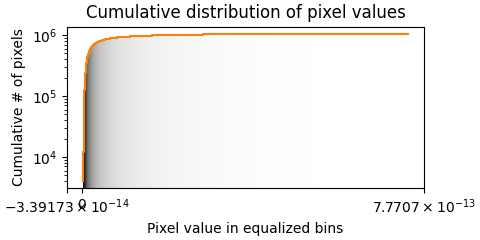

In [12]:
# What if we wanted to reproject the data to a new arbitrary coordinate frame?
# First, define a new target WCS
new_wcs = deepcopy(data_map.wcs)
new_wcs.wcs.ctype = 'HPLN-ARC', 'HPLT-ARC'
new_wcs.wcs.cunit = 'deg', 'deg'
new_wcs.array_shape = 1024, 1024
new_wcs.wcs.crpix = 512, 512
new_wcs.wcs.crval = 10, 10  
new_wcs.wcs.cdelt = 0.0225, 0.0225
new_wcs.wcs.pc = (0.66,-0.33), (0.33,0.66) 

# We can then reproject using SunPy maps
new_map = data_map.reproject_to(new_wcs)
new_map

## Using NDCube

So far, we've only talked about directly manipulating the data or using SunPy Maps. However, we encourage you to utilize NDCubes. We use them in the data reduction pipeline too. [NDCube](https://docs.sunpy.org/projects/ndcube/en/stable/introduction.html) is a SunPy package for generalized n-dimensional data. We can use our manually loaded data to make an NDCube with all of the data in one place. There's even a way to bundle uncertainty direclty into the cube. 

In [13]:
data_ndcube = NDCube(data, wcs=data_wcs, meta=header, uncertainty=uncertainty)
data_ndcube

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


NDCube
------
Dimensions: [2.000e+00 4.096e+03 4.096e+03] pix
Physical Types of Axes: [('phys.polarization.stokes',), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]
Unit: None
Data Type: float32

We can then use all the great NDCube functionality! Much like SunPy Maps we can reproject even. Note that as of writing this guide, the uncertainty is dropped when NDCube reprojects data. 

In [14]:
# make a target WCS
new_wcs = deepcopy(data_wcs)
new_wcs.wcs.ctype = 'HPLN-ARC', 'HPLT-ARC', 'STOKES'
new_wcs.wcs.cunit = 'deg', 'deg', ''
new_wcs.array_shape = 2, 1024, 1024
new_wcs.wcs.crpix = 0, 0, 0
new_wcs.wcs.crval = 0, 0, 0
new_wcs.wcs.cdelt = 0.0225, 0.0225, 1.0

new_cube = data_ndcube.reproject_to(new_wcs)
new_cube

NDCube
------
Dimensions: [   2. 1024. 1024.] pix
Physical Types of Axes: [('phys.polarization.stokes',), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]
Unit: None
Data Type: float64

NDCubes have a plotter on them too. Notice we even get an interactive slider to manipulate the polarization axis.

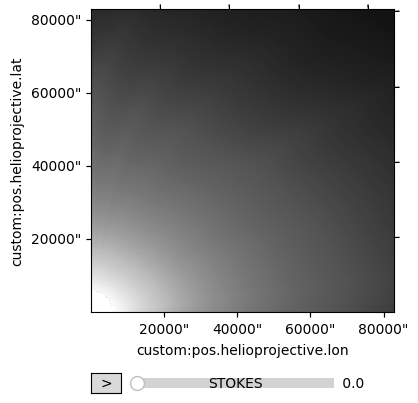

In [15]:
new_cube.plot(interpolation='None', norm=LogNorm(vmin=1.77E-15, vmax=3.7E-11), cmap='Greys_r')

We encourage you to explore NDCube more. There are other helpful things like [cropping](https://docs.sunpy.org/projects/ndcube/en/stable/generated/gallery/slicing_ndcube.html#cropping-cube-using-world-coordinate-values-using-ndcube-ndcube-crop) that you can do. 

## Uncertainty

Level 1, 2, and 3 PUNCH products come with an uncertainty estimate. This uncertainty is expressed as the fractional uncertainty ranging from 0 to 1. To get the absolute uncertainty, simply multiply the fractional uncertainty by the data value.

There's an extra step though. Uncertainty is encoded as an integer in the FITS file to save space. When we inspect the uncertainty, we see it ranges from 0 to 255. Here, 255 correpsonds to a fractional uncertainty of 1.0 or complete uncertainty.

In [21]:
print(uncertainty.min(), uncertainty.max())  # values range from 0 to 255

absolute_uncertainty = uncertainty.astype(float) / 255 * data
print(absolute_uncertainty.min(), absolute_uncertainty.max())  # now the uncertainty is in the same units as the data

1 255
0.0 3.780833285338403e-11


Let's plot the data and uncertainty to get a feel for it. As mentioned earlier, analysis and visualization tools that make this easier will be released with the `punchbowl` package. 

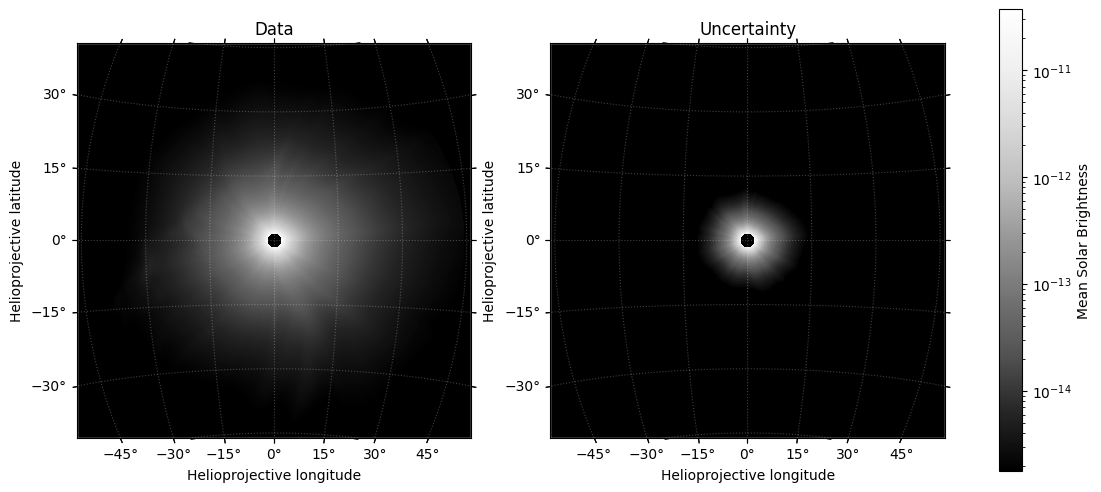

In [22]:
vmin, vmax = 1.77E-15, 3.7E-11

fig, axs = plt.subplots(figsize=(14, 6), ncols=2, subplot_kw={'projection':data_wcs[0]})

im = axs[0].imshow(data[0], norm=LogNorm(vmin=vmin, vmax=vmax), interpolation='None', cmap='Greys_r')
axs[0].set_title("Data")

axs[1].imshow(absolute_uncertainty[0], norm=LogNorm(vmin=vmin, vmax=vmax), interpolation='None', cmap='Greys_r')
axs[1].set_title("Uncertainty")

fig.colorbar(im, ax=axs, label='Mean Solar Brightness')

# set up the axis labels
for ax in axs:
    lon, lat = ax.coords
    lat.set_ticks(np.arange(-90, 90, 15) * u.degree)
    lon.set_ticks(np.arange(-180, 180, 15) * u.degree)
    lat.set_major_formatter('dd')
    lon.set_major_formatter('dd')
    ax.set_facecolor('black')
    ax.coords.grid(color='white', alpha=.25, ls='dotted')
    ax.set_xlabel("Helioprojective longitude")
    ax.set_ylabel("Helioprojective latitude")